
## Problem Statement : Forecasting Avocado Sale Prices in USA


### Content

   
   
   The table below represents weekly 2018 retail scan data for National retail volume (units) and price. Retail scan data comes directly from retailers’ cash registers based on actual retail sales of Hass avocados. Starting in 2013, the table below reflects an expanded, multi-outlet retail data set. Multi-outlet reporting includes an aggregation of the following channels: grocery, mass, club, drug, dollar and military. 

   The Average Price (of avocados) in the table reflects a per unit (per avocado) cost, even when multiple units (avocados) are sold in bags. The Product Lookup codes (PLU’s) in the table are only for Hass avocados. Other varieties of avocados (e.g. greenskins) are not included in this table.

Some relevant columns in the dataset:

1. Date - The date of the observation
2. AveragePrice - the average price of a single avocado
3. type - conventional or organic
4. year - the year
5. Region - the city or region of the observation
6. Total Volume - Total number of avocados sold
7. 4046 - Total number of avocados with PLU 4046 sold
8. 4225 - Total number of avocados with PLU 4225 sold
9. 4770 - Total number of avocados with PLU 4770 sold



### Importing Libraries and Reading Data

In [177]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
sns.set_style("dark")
from fbprophet import Prophet
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('avocado.csv')

df.shape
# Data has 18249 Rows and 14 Columns

(18249, 14)

- Prophet is open source library released by Facebook’s Core Data Science team for python forecasting purposes.

- Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects.

- Prophet works best with time series that have strong seasonal effects and several seasons of historical data.

- For more information, please check this out: https://research.fb.com/prophet-forecasting-at-scale/ https://facebook.github.io/prophet/docs/quick_start.html#python-api

### Exploratory Data Analysis

In [178]:
# Understanding Data
df.isnull().sum()

# We have no null points to start with, a better dataset indeed!

Unnamed: 0      0
Date            0
AveragePrice    0
Total Volume    0
4046            0
4225            0
4770            0
Total Bags      0
Small Bags      0
Large Bags      0
XLarge Bags     0
type            0
year            0
region          0
dtype: int64

In [179]:
df.info()
# This will give Index, Datatype and Memory information

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    18249 non-null  int64  
 1   Date          18249 non-null  object 
 2   AveragePrice  18249 non-null  float64
 3   Total Volume  18249 non-null  float64
 4   4046          18249 non-null  float64
 5   4225          18249 non-null  float64
 6   4770          18249 non-null  float64
 7   Total Bags    18249 non-null  float64
 8   Small Bags    18249 non-null  float64
 9   Large Bags    18249 non-null  float64
 10  XLarge Bags   18249 non-null  float64
 11  type          18249 non-null  object 
 12  year          18249 non-null  int64  
 13  region        18249 non-null  object 
dtypes: float64(9), int64(2), object(3)
memory usage: 1.9+ MB


In [180]:
df.describe()
# From this we can get the min,max etc values of every column that can be operated arithmetically

,Unnamed: 0,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,year
count,18249.000000,18249.000000,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,18249.000000,18249.000000
mean,24.232232,1.405978,8.506440e+05,2.930084e+05,2.951546e+05,2.283974e+04,2.396392e+05,1.821947e+05,5.433809e+04,3106.426507,2016.147899
std,15.481045,0.402677,3.453545e+06,1.264989e+06,1.204120e+06,1.074641e+05,9.862424e+05,7.461785e+05,2.439660e+05,17692.894652,0.939938
min,0.000000,0.440000,8.456000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,2015.000000
25%,10.000000,1.100000,1.083858e+04,8.540700e+02,3.008780e+03,0.000000e+00,5.088640e+03,2.849420e+03,1.274700e+02,0.000000,2015.000000
50%,24.000000,1.370000,1.073768e+05,8.645300e+03,2.906102e+04,1.849900e+02,3.974383e+04,2.636282e+04,2.647710e+03,0.000000,2016.000000
75%,38.000000,1.660000,4.329623e+05,1.110202e+05,1.502069e+05,6.243420e+03,1.107834e+05,8.333767e+04,2.202925e+04,132.500000,2017.000000
max,52.000000,3.250000,6.250565e+07,2.274362e+07,2.047057e+07,2.546439e+06,1.937313e+07,1.338459e+07,5.719097e+06,551693.650000,2018.000000


In [181]:
# Dropping un-necessary columns

df = df.drop(['Unnamed: 0'], axis = 1)
df.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [182]:
#convert the data column from object datatype to datetype

df['Date'] = pd.to_datetime(df['Date'])

df['Month']=df['Date'].apply(lambda x:x.month)
df['Day']=df['Date'].apply(lambda x:x.day)
df = df.sort_values("Date")

# checking the initial and last dates

df['Date'].head(),df['Date'].tail()

(11569   2015-01-04
 9593    2015-01-04
 10009   2015-01-04
 1819    2015-01-04
 9333    2015-01-04
 Name: Date, dtype: datetime64[ns],
 8574    2018-03-25
 9018    2018-03-25
 18141   2018-03-25
 17673   2018-03-25
 8814    2018-03-25
 Name: Date, dtype: datetime64[ns])

In [183]:
df # Month, Day columns have been added

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,Month,Day
11569,2015-01-04,1.75,27365.89,9307.34,3844.81,615.28,13598.46,13061.10,537.36,0.00,organic,2015,Southeast,1,4
9593,2015-01-04,1.49,17723.17,1189.35,15628.27,0.00,905.55,905.55,0.00,0.00,organic,2015,Chicago,1,4
10009,2015-01-04,1.68,2896.72,161.68,206.96,0.00,2528.08,2528.08,0.00,0.00,organic,2015,HarrisburgScranton,1,4
1819,2015-01-04,1.52,54956.80,3013.04,35456.88,1561.70,14925.18,11264.80,3660.38,0.00,conventional,2015,Pittsburgh,1,4
9333,2015-01-04,1.64,1505.12,1.27,1129.50,0.00,374.35,186.67,187.68,0.00,organic,2015,Boise,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8574,2018-03-25,1.36,908202.13,142681.06,463136.28,174975.75,127409.04,103579.41,22467.04,1362.59,conventional,2018,Chicago,3,25
9018,2018-03-25,0.70,9010588.32,3999735.71,966589.50,30130.82,4014132.29,3398569.92,546409.74,69152.63,conventional,2018,SouthCentral,3,25
18141,2018-03-25,1.42,163496.70,29253.30,5080.04,0.00,129163.36,109052.26,20111.10,0.00,organic,2018,SouthCentral,3,25
17673,2018-03-25,1.70,190257.38,29644.09,70982.10,0.00,89631.19,89424.11,207.08,0.00,organic,2018,California,3,25


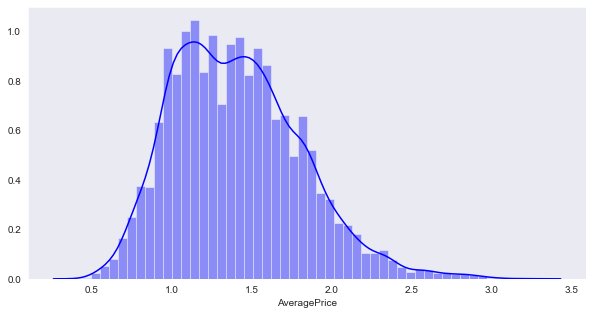

In [184]:
plt.figure(figsize = [10,5])

sns.distplot(df["AveragePrice"], color = 'blue')

# The Avocado's price are largely concentrated in the range of 0.75 - 2.0 USD per fruit

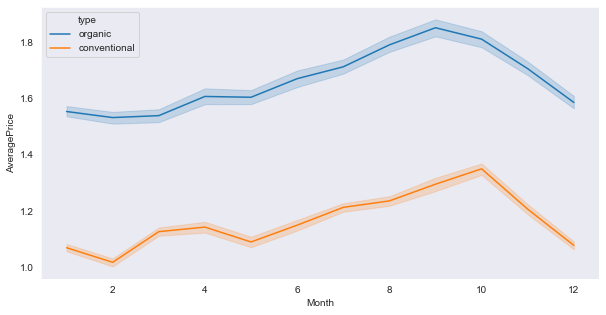

In [185]:
plt.figure(figsize=(10,5))
sns.lineplot(x="Month", y="AveragePrice", hue='type', data=df)
plt.show()

# Looks like there was a hike between months 8 – 10 for both Conventional and Organic type of Avocados prices

In [186]:
df_type_price = df[['type','AveragePrice']].groupby(['type']).mean().sort_values('AveragePrice',ascending = False)

df_type_price

# Observed that typically organic is costlier than conventional, forecasted the organic and conventional prices
# in the forecast section

,AveragePrice
type,
organic,1.653999
conventional,1.158040


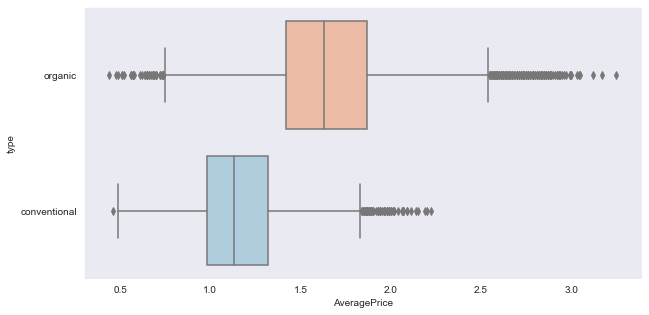

In [187]:
plt.figure(figsize=(10,5))
sns.boxplot(y=df['type'], x=df['AveragePrice'],  palette = 'RdBu')

# The mean price of organic avocado is slightly higher than 1.5 USD
# The mean price of conventional avocado is slightly higher than 1.0 USD

Text(0.5, 1.0, 'Average Price of Avocado According to Region')

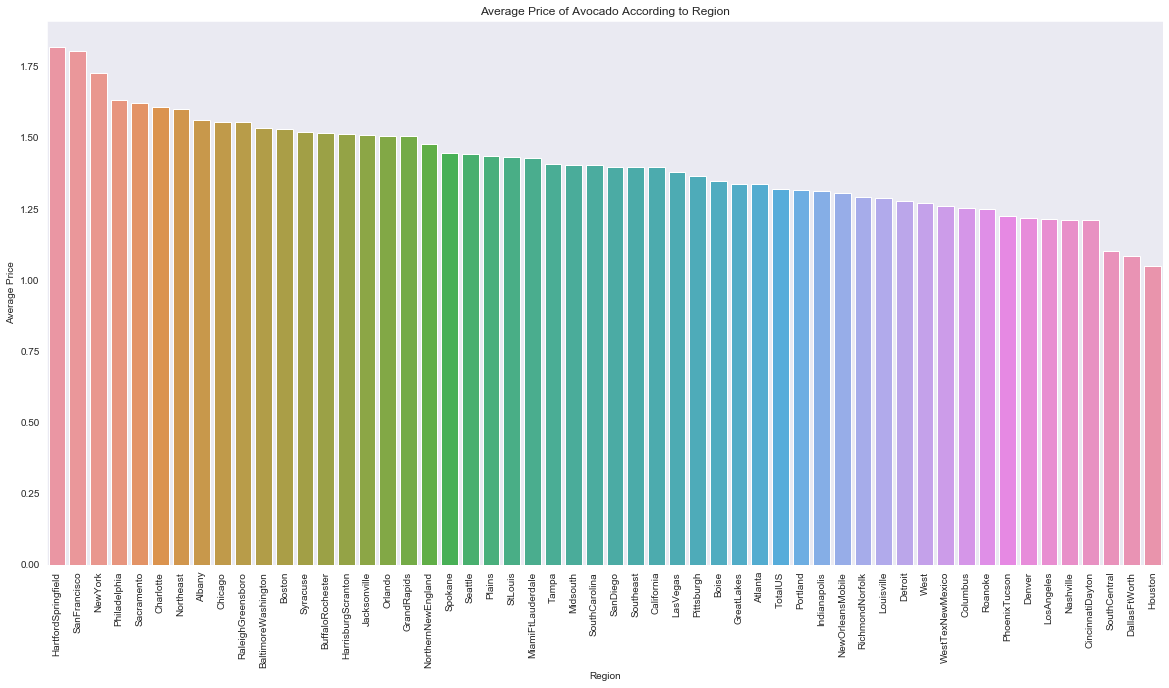

In [188]:
# Understandong region wise avocado prices using groupby
region_list=list(df.region.unique())
average_price=[]

for i in region_list:
    x=df[df.region==i]
    region_average=sum(x.AveragePrice)/len(x)
    average_price.append(region_average)

df1=pd.DataFrame({'region_list':region_list,'average_price':average_price})
new_index=df1.average_price.sort_values(ascending=False).index.values
sorted_data=df1.reindex(new_index)

plt.figure(figsize=(20,10))
ax=sns.barplot(x=sorted_data.region_list,y=sorted_data.average_price)

plt.xticks(rotation=90)
plt.xlabel('Region')
plt.ylabel('Average Price')
plt.title('Average Price of Avocado According to Region')


# Graphically we understood that HartfordSpringfield, SanFrancisco, NewYork, Philadelphia, Sacramento are costly

In [189]:
# Understandong region wise avocado prices using groupby

df_region_price = df[['region','AveragePrice','Total Volume']].groupby(['region']).mean().sort_values(
        'AveragePrice',
        ascending = False)

df_region_price.head()

# Region wise sales

# Both Visually and numerically we got the same regions in top 5 pricings of avocado.

,AveragePrice,Total Volume
region,,
HartfordSpringfield,1.818639,149912.832722
SanFrancisco,1.804201,401864.472722
NewYork,1.727574,712231.146538
Philadelphia,1.632130,212540.823018
Sacramento,1.621568,222377.949290


### Q) In which regions can millenials have their avocado toast AND buy a home?

We can see that the regions - *'HartfordSpringfield', 'SanFrancisco', 'NewYork'* has the top three avocado prices making it very costly choice for a avocado toast!

Text(0.5, 1.0, 'Average of Total Volume According to Region')

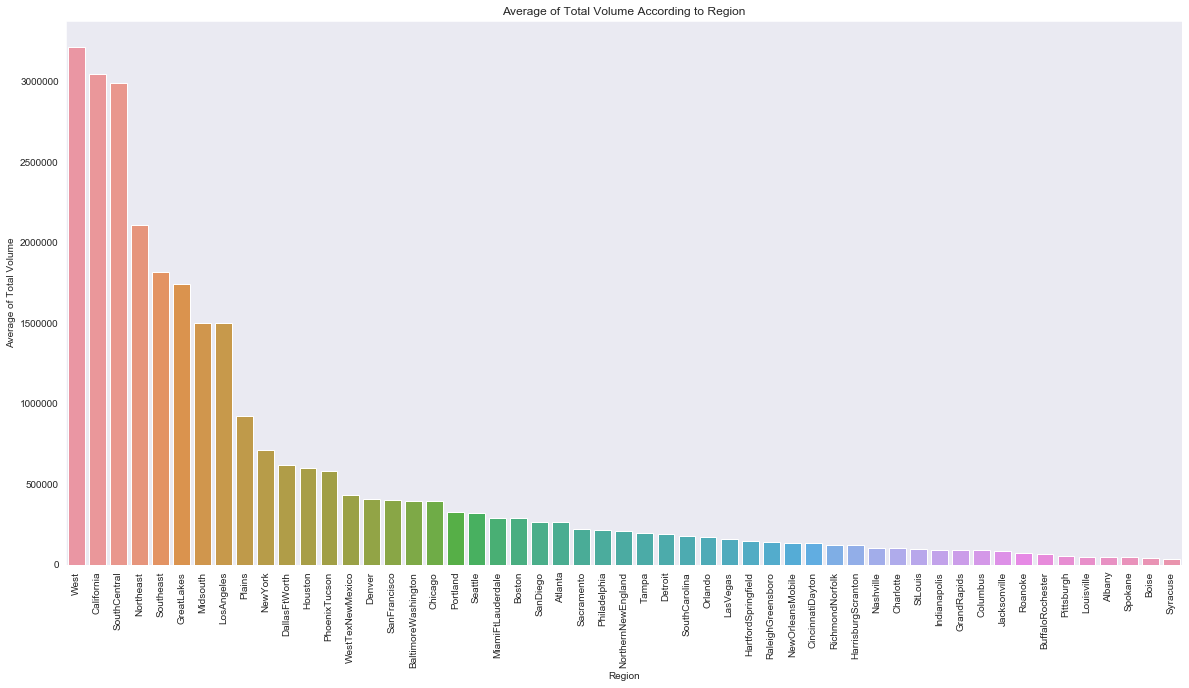

In [190]:
filter1=df.region!='TotalUS'
df1=df[filter1]

region_list=list(df1.region.unique())
average_total_volume=[]

for i in region_list:
    x=df1[df1.region==i]
    average_total_volume.append(sum(x['Total Volume'])/len(x))
df3=pd.DataFrame({'region_list':region_list,'average_total_volume':average_total_volume})

new_index=df3.average_total_volume.sort_values(ascending=False).index.values
sorted_data1=df3.reindex(new_index)

plt.figure(figsize=(20,10))
ax=sns.barplot(x=sorted_data1.region_list,y=sorted_data1.average_total_volume)

plt.xticks(rotation=90)
plt.xlabel('Region')
plt.ylabel('Average of Total Volume')
plt.title('Average of Total Volume According to Region')

# It is clear that West, California and South Central regions demand more volumes of avocados

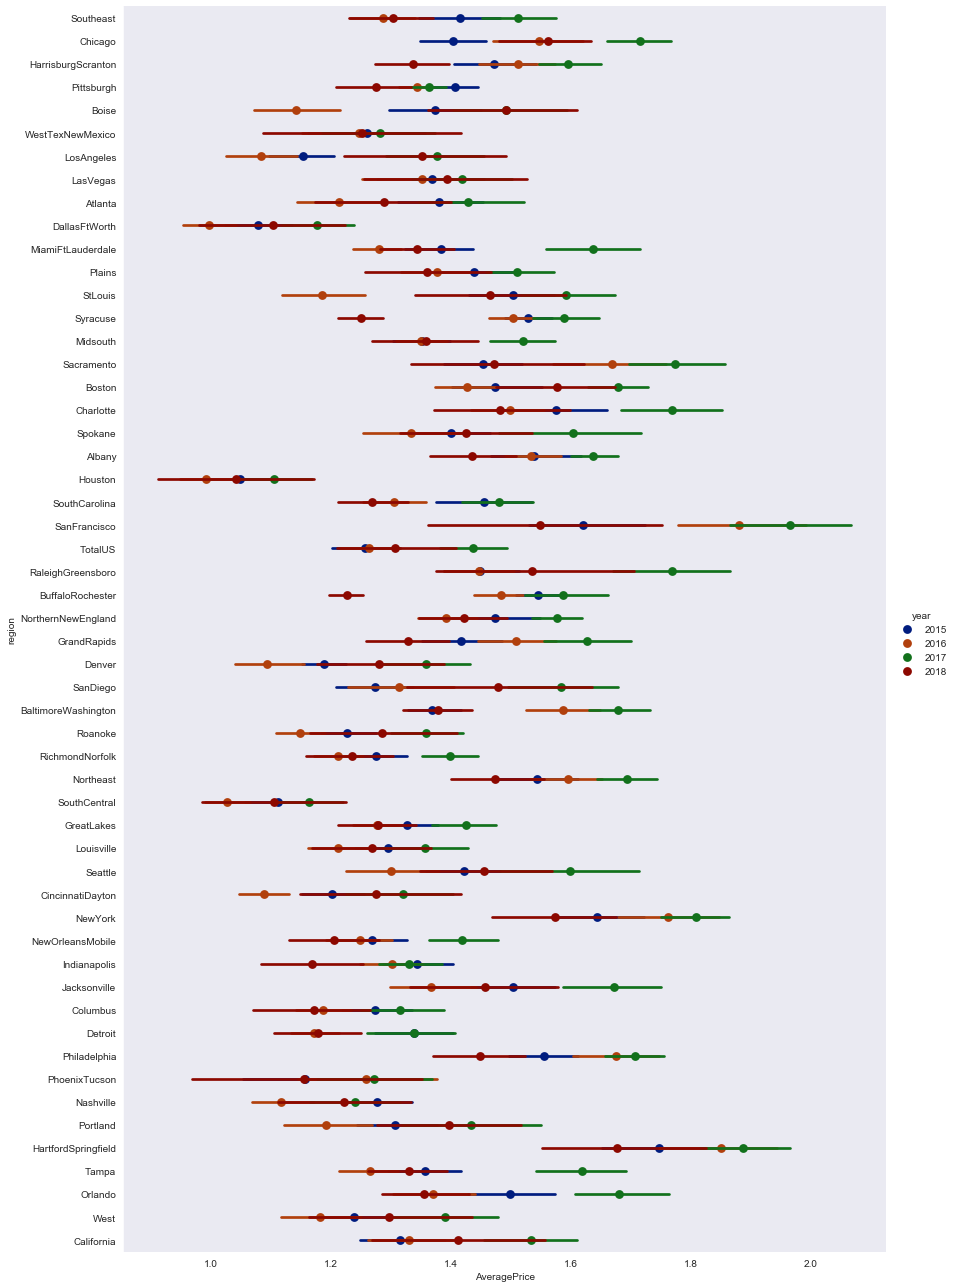

In [191]:
g = sns.factorplot('AveragePrice','region',data=df,
                   hue='year',
                   size=18,
                   aspect=0.7,
                   palette='dark',
                   join=False,)

# A huge increase in Avocado prices as the demand was little high in Year 2017 in SanFranciso region. 
# Houston contiously fared low in prices getting lowest in 2018

In [192]:
df['total_sales'] = df['AveragePrice'] * df['Total Volume']

df.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,Month,Day,total_sales
11569,2015-01-04,1.75,27365.89,9307.34,3844.81,615.28,13598.46,13061.10,537.36,0.0,organic,2015,Southeast,1,4,47890.3075
9593,2015-01-04,1.49,17723.17,1189.35,15628.27,0.00,905.55,905.55,0.00,0.0,organic,2015,Chicago,1,4,26407.5233
10009,2015-01-04,1.68,2896.72,161.68,206.96,0.00,2528.08,2528.08,0.00,0.0,organic,2015,HarrisburgScranton,1,4,4866.4896
1819,2015-01-04,1.52,54956.80,3013.04,35456.88,1561.70,14925.18,11264.80,3660.38,0.0,conventional,2015,Pittsburgh,1,4,83534.3360
9333,2015-01-04,1.64,1505.12,1.27,1129.50,0.00,374.35,186.67,187.68,0.0,organic,2015,Boise,1,4,2468.3968


In [193]:
df = df.sort_values('Date')
df.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,Month,Day,total_sales
11569,2015-01-04,1.75,27365.89,9307.34,3844.81,615.28,13598.46,13061.10,537.36,0.00,organic,2015,Southeast,1,4,47890.3075
11829,2015-01-04,1.46,612910.15,233286.13,216611.20,4370.99,158641.83,115068.71,43573.12,0.00,organic,2015,TotalUS,1,4,894848.8190
11777,2015-01-04,1.70,1885.48,748.62,30.19,0.00,1106.67,1106.67,0.00,0.00,organic,2015,Tampa,1,4,3205.3160
675,2015-01-04,0.99,668086.00,117454.09,429518.41,5553.60,115559.90,67894.33,47661.52,4.05,conventional,2015,Denver,1,4,661405.1400
1247,2015-01-04,0.92,101162.98,1991.63,75090.16,283.88,23797.31,7769.36,16027.95,0.00,conventional,2015,Louisville,1,4,93069.9416


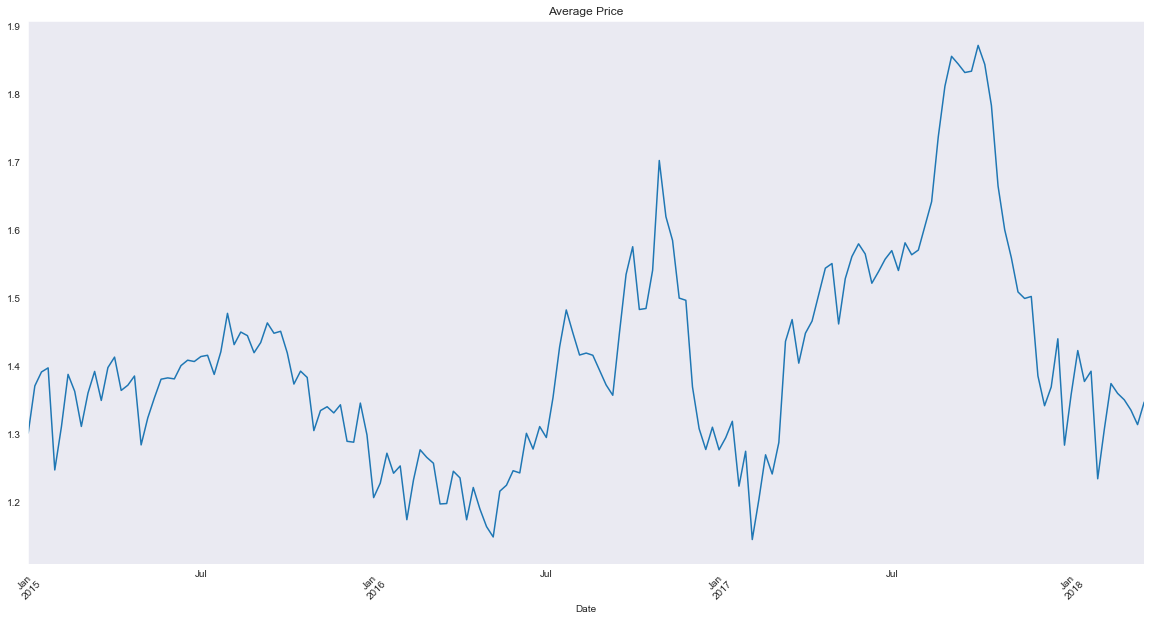

In [194]:
byDate=df.groupby('Date').mean()
plt.figure(figsize=(20,10))
byDate['AveragePrice'].plot()
plt.title('Average Price')
plt.xticks(rotation = 45 )
sns.set_style("darkgrid")

# This also shows there was a huge hike in prices after July 2017 and before Jan 2018. 
# This was also confirmed in earlier graph too.

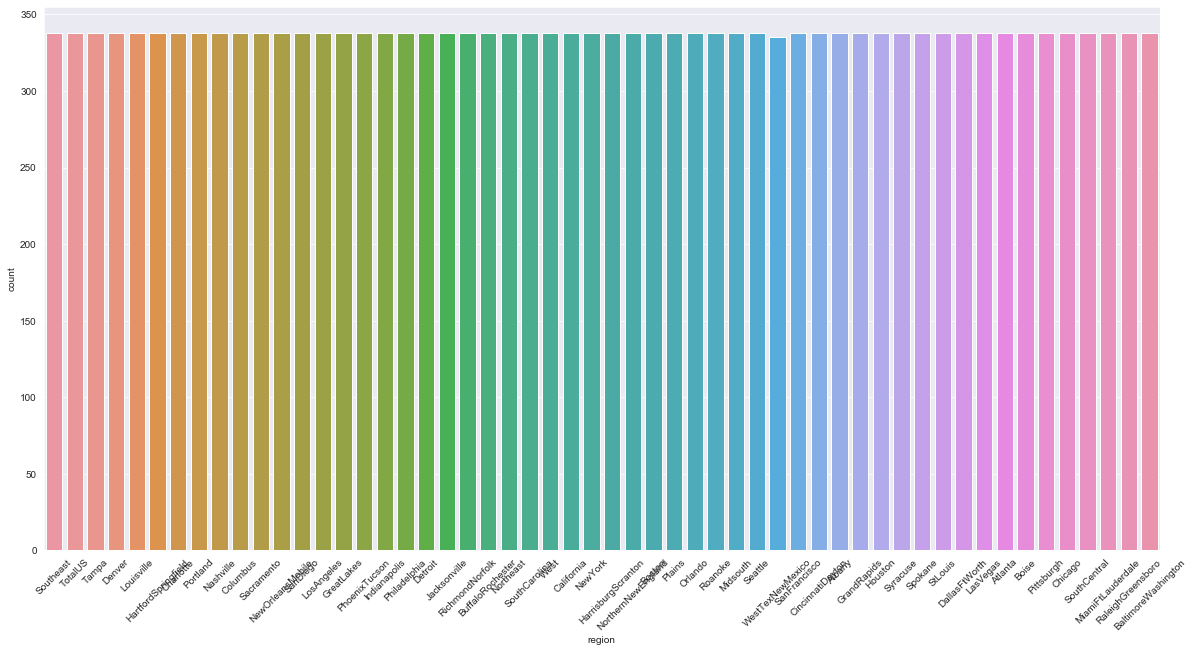

In [195]:
plt.figure(figsize = [20,10])
plt.xticks(rotation = 45 )
sns.countplot(df['region'])
sns.set_style("dark")


# we have similiar number of datapoints for everyregion mentioned

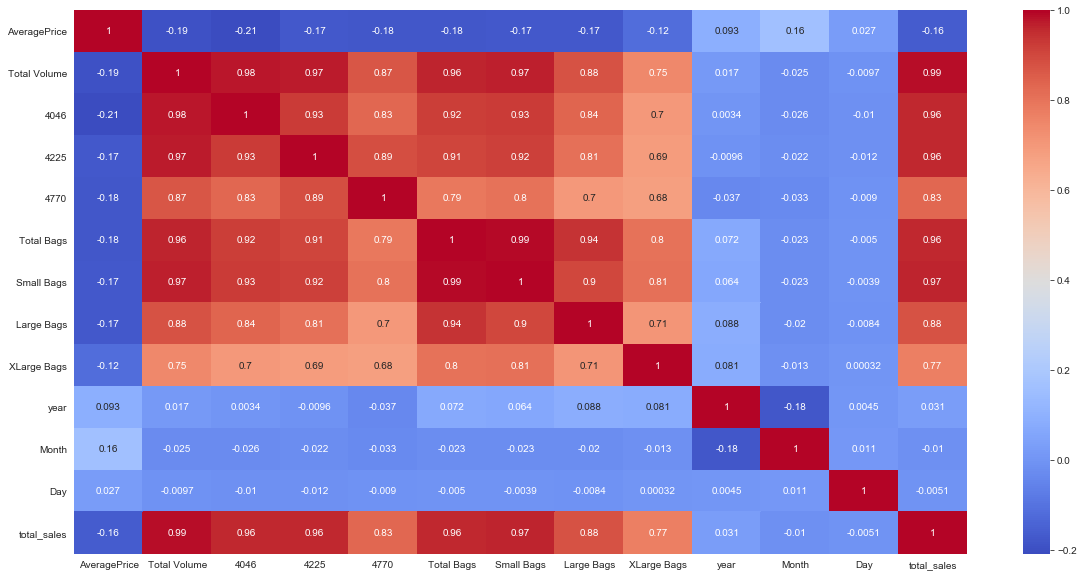

In [196]:
plt.figure(figsize=(20,10))
sns.heatmap(df.corr(),cmap='coolwarm',annot=True)

#As we can from the heatmap above, all the Features are not correleted with the Average Price column, 
# This might affect as this will not help us get a good model. Lets see

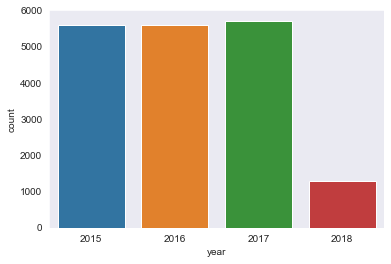

In [197]:
sns.countplot(df['year'])

# Lesser number of records from 2018 is because the data could have been extracted before completetion of 2018 FY.

In [198]:
df2 = df[['Date','AveragePrice']]

df2

,Date,AveragePrice
11569,2015-01-04,1.75
11829,2015-01-04,1.46
11777,2015-01-04,1.70
675,2015-01-04,0.99
1247,2015-01-04,0.92
...,...,...
8670,2018-03-25,1.21
17997,2018-03-25,1.52
17733,2018-03-25,1.46
8706,2018-03-25,1.05


## Modelling using fb prophet

In [199]:

df2 = df2.rename(columns = {'Date':'ds','AveragePrice':'y'}) # for the reason that prophet accepts only ds, y
df2.head()

,ds,y
11569,2015-01-04,1.75
11829,2015-01-04,1.46
11777,2015-01-04,1.70
675,2015-01-04,0.99
1247,2015-01-04,0.92


In [200]:
m = Prophet()
m.fit(df2)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


## Forecasting

In [201]:
# forecasting the future prices

future = m.make_future_dataframe(periods = 450)

forecast1 = m.predict(future)


In [239]:
forecast1[['ds','yhat','yhat_lower','yhat_upper']]

# 1.097 - Forecast as on 18 -6-2019
# 1.351 - Price on 25-03-2018

,ds,yhat,yhat_lower,yhat_upper
0,2015-01-04,1.384244,0.871318,1.839256
1,2015-01-04,1.384244,0.891697,1.907484
2,2015-01-04,1.384244,0.930708,1.878589
3,2015-01-04,1.384244,0.877416,1.861993
4,2015-01-04,1.384244,0.886974,1.872766
...,...,...,...,...
18694,2019-06-14,1.101921,0.547983,1.637554
18695,2019-06-15,1.100815,0.508046,1.648381
18696,2019-06-16,1.099646,0.514662,1.642561
18697,2019-06-17,1.098445,0.542583,1.629840


## Predicting accuracy from original hass avocado site

- *https://hassavocadoboard.com/category-data/?region=Total+U.S.&y=2018*

***Real data taken from Hass avocados site***
- Average -01/04 = USD 1.325
- Average -08/04 = USD 1.295

***Predicted data from forecast-1***
- Average-01/04 = USD 1.360708286
- Average -08/04 = USD 1.373267

**Accuracy in 2018 Mar 26 - Apr 8 = 95.83%**


***Real data taken from Hass avocados site***
- Average -06/05 = USD 1.22
- Average -13/05 = USD 1.265

***Predicted data from forecast-1***
- Average -06/05 = USD 1.327687
- Average -13/05 = 1.329330571
**Accuracy in 2018 Apr 30 - May 13 = 93.53%**

### Overall Accuracy for next one month is 94.68%

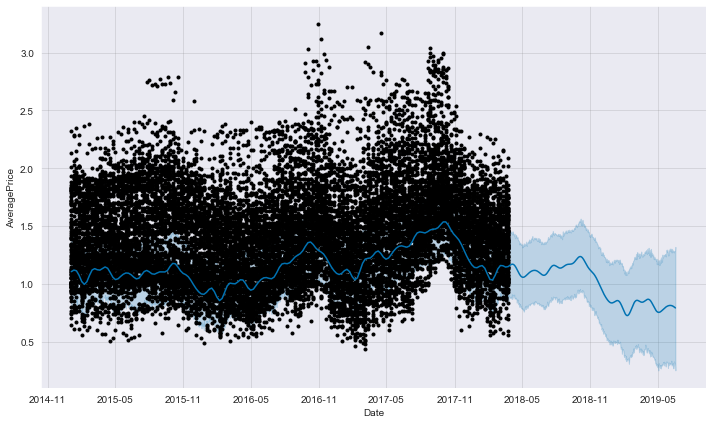

In [203]:
fig = m.plot(forecast, xlabel = 'Date', ylabel = 'AveragePrice')

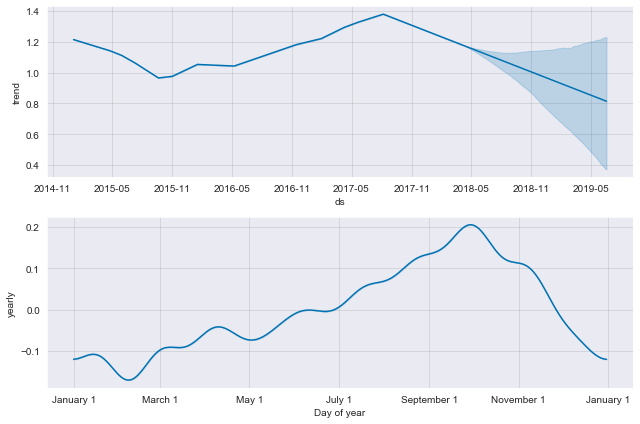

In [204]:
fig2 = m.plot_components(forecast)

In [205]:
df.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,Month,Day,total_sales
11569,2015-01-04,1.75,27365.89,9307.34,3844.81,615.28,13598.46,13061.10,537.36,0.00,organic,2015,Southeast,1,4,47890.3075
11829,2015-01-04,1.46,612910.15,233286.13,216611.20,4370.99,158641.83,115068.71,43573.12,0.00,organic,2015,TotalUS,1,4,894848.8190
11777,2015-01-04,1.70,1885.48,748.62,30.19,0.00,1106.67,1106.67,0.00,0.00,organic,2015,Tampa,1,4,3205.3160
675,2015-01-04,0.99,668086.00,117454.09,429518.41,5553.60,115559.90,67894.33,47661.52,4.05,conventional,2015,Denver,1,4,661405.1400
1247,2015-01-04,0.92,101162.98,1991.63,75090.16,283.88,23797.31,7769.36,16027.95,0.00,conventional,2015,Louisville,1,4,93069.9416


In [206]:
# Now we will predict prices based on region

df_sample = df[df['region']=='Chicago'][['Date','AveragePrice','region']]
df_sample.head()


,Date,AveragePrice,region
9593,2015-01-04,1.49,Chicago
467,2015-01-04,1.11,Chicago
466,2015-01-11,1.15,Chicago
9592,2015-01-11,1.79,Chicago
465,2015-01-18,1.14,Chicago


In [207]:
df_sample_model = df_sample.drop(['region'], axis = 1)
df_sample_model = df_sample_model.rename(columns = {'Date':'ds','AveragePrice':'y'})


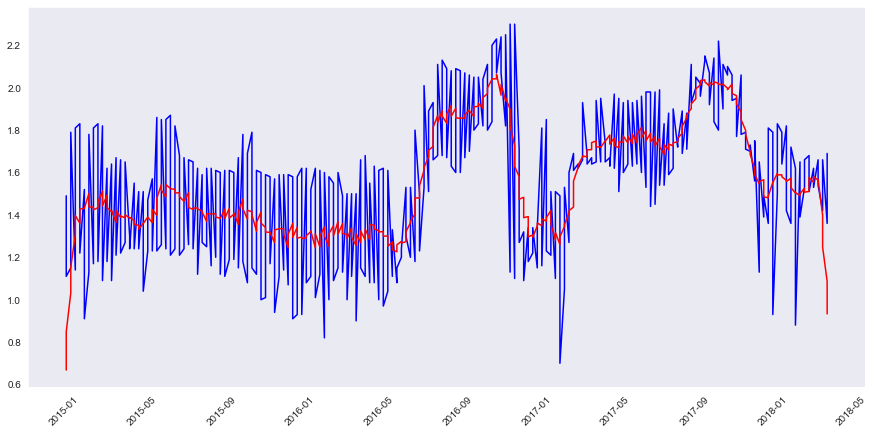

In [208]:
from __future__ import division
from pylab import plot, ylim, xlim, show, xlabel, ylabel, grid
from numpy import linspace, loadtxt, ones, convolve
import matplotlib.dates as mdates
import matplotlib.cbook as cbook


plt.figure(figsize = [15,7])

plt.xticks (rotation = 45)

# plt.plot(df_sample.Date, df_sample.AveragePrice)

# Moving average  of graph of windowsize = 10

def movingaverage(interval, window_size):
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

x = df_sample.Date
y = df_sample.AveragePrice


plot(x,y,"b")
y_av = movingaverage(y, 10)
plot(x, y_av,"r")

# xlabel("Months since Jan 1749.")
# ylabel("No. of Sun spots")
show()

In [209]:
m = Prophet()
m.fit(df_sample_model)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [210]:
future = m.make_future_dataframe(periods = 500)

forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-04,1.423096,0.890139,1.569394,1.423096,1.423096,-0.175979,-0.175979,-0.175979,-0.175979,-0.175979,-0.175979,0.0,0.0,0.0,1.247117
1,2015-01-04,1.423096,0.900019,1.600324,1.423096,1.423096,-0.175979,-0.175979,-0.175979,-0.175979,-0.175979,-0.175979,0.0,0.0,0.0,1.247117
2,2015-01-11,1.422914,1.018071,1.679320,1.422914,1.422914,-0.076116,-0.076116,-0.076116,-0.076116,-0.076116,-0.076116,0.0,0.0,0.0,1.346797
3,2015-01-11,1.422914,1.022232,1.700896,1.422914,1.422914,-0.076116,-0.076116,-0.076116,-0.076116,-0.076116,-0.076116,0.0,0.0,0.0,1.346797
4,2015-01-18,1.422731,1.005920,1.705261,1.422731,1.422731,-0.070230,-0.070230,-0.070230,-0.070230,-0.070230,-0.070230,0.0,0.0,0.0,1.352501


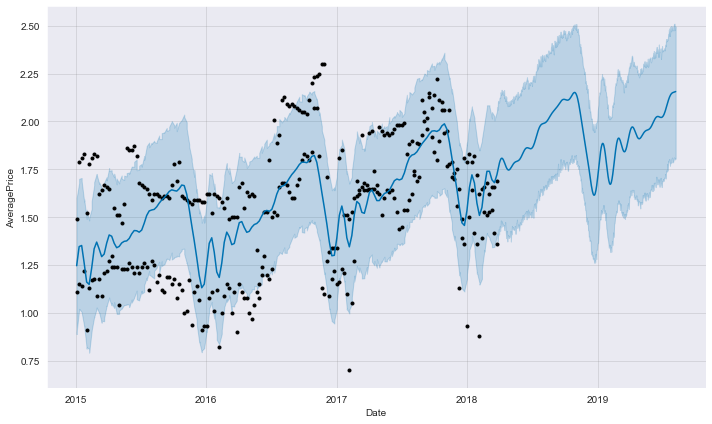

In [211]:
fig3 = m.plot(forecast, xlabel = 'Date', ylabel = 'AveragePrice')

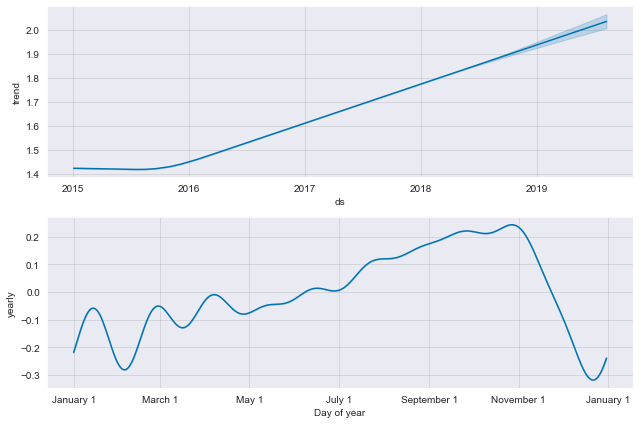

In [212]:
fig4 = m.plot_components(forecast)

# we can see that for 'Chicago' region the trend is upwards and every year the prices peak during ending
# of october month and dips to year's low during dec-jan transition time



In [213]:
# Forecasting organic avocados price for next 500 days from last date of available price

df_sample_organic = df[df['type'] == 'organic'][['AveragePrice','Date']]

df_sample_organic = df_sample_organic.rename(columns = {'Date':'ds','AveragePrice':'y'})

m = Prophet()
m.fit(df_sample_organic)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [214]:
df_sample_organic.head()

,y,ds
11569,1.75,2015-01-04
11829,1.46,2015-01-04
11777,1.70,2015-01-04
10061,2.32,2015-01-04
9541,2.13,2015-01-04


In [215]:
future = m.make_future_dataframe(periods = 450)

forecast = m.predict(future)

forecast.tail(10)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
9563,2019-06-09,1.368792,0.879090,1.825246,1.178321,1.556849,-0.008797,-0.008797,-0.008797,-0.008797,-0.008797,-0.008797,0.0,0.0,0.0,1.359994
9564,2019-06-10,1.368131,0.883454,1.814219,1.177128,1.556866,-0.007705,-0.007705,-0.007705,-0.007705,-0.007705,-0.007705,0.0,0.0,0.0,1.360426
9565,2019-06-11,1.367470,0.878070,1.833783,1.175263,1.556906,-0.006724,-0.006724,-0.006724,-0.006724,-0.006724,-0.006724,0.0,0.0,0.0,1.360746
9566,2019-06-12,1.366809,0.883437,1.832224,1.173940,1.557023,-0.005830,-0.005830,-0.005830,-0.005830,-0.005830,-0.005830,0.0,0.0,0.0,1.360978
9567,2019-06-13,1.366148,0.870486,1.833111,1.172723,1.557140,-0.004997,-0.004997,-0.004997,-0.004997,-0.004997,-0.004997,0.0,0.0,0.0,1.361151
9568,2019-06-14,1.365487,0.899904,1.837099,1.171574,1.557256,-0.004192,-0.004192,-0.004192,-0.004192,-0.004192,-0.004192,0.0,0.0,0.0,1.361294
9569,2019-06-15,1.364826,0.869581,1.828405,1.170472,1.557373,-0.003387,-0.003387,-0.003387,-0.003387,-0.003387,-0.003387,0.0,0.0,0.0,1.361439
9570,2019-06-16,1.364165,0.885539,1.825293,1.169024,1.557490,-0.002548,-0.002548,-0.002548,-0.002548,-0.002548,-0.002548,0.0,0.0,0.0,1.361616
9571,2019-06-17,1.363504,0.832049,1.827039,1.167736,1.557606,-0.001646,-0.001646,-0.001646,-0.001646,-0.001646,-0.001646,0.0,0.0,0.0,1.361857
9572,2019-06-18,1.362843,0.914177,1.798803,1.166502,1.557710,-0.000652,-0.000652,-0.000652,-0.000652,-0.000652,-0.000652,0.0,0.0,0.0,1.362191


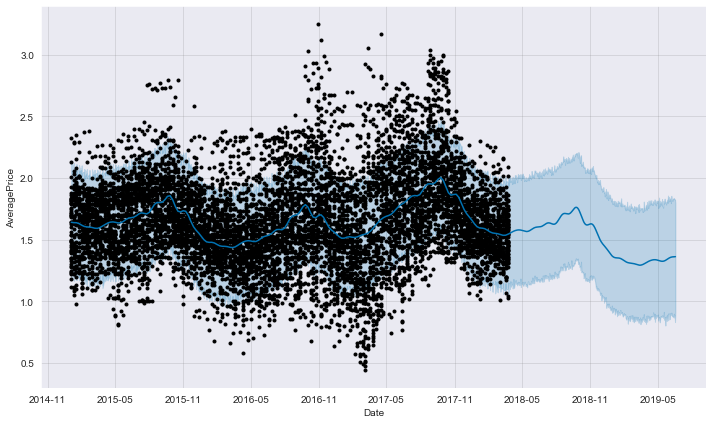

In [216]:
fig5 = m.plot(forecast, xlabel = 'Date', ylabel = 'AveragePrice')

# Organic avocados are expected to go cheaper in 2019 summer when compared to 2018 summer and even 2017 summer!

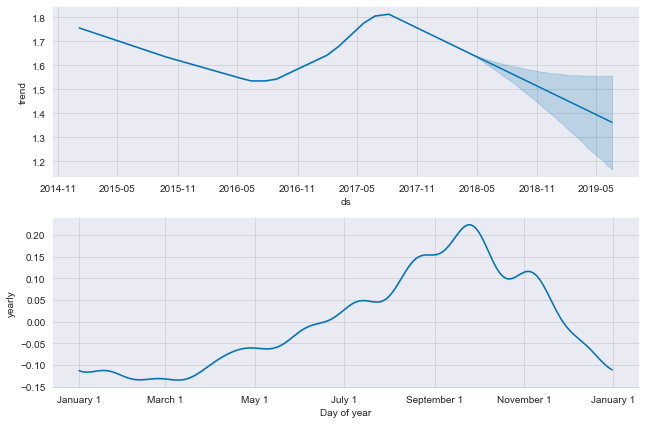

In [217]:
fig6 = m.plot_components(forecast)

# The discussed trend can be stregthened by seeing the forecast of prices and the range of organice avocados could be
# in the range of 1.1 - 1.55 USD per fruit in 2019 summer


# On a yearly basis organic avocado prices follow similiar trend of whole batch, i.e reaches peak during month of 
# October.

In [218]:
# Forecasting conventional avocados price for next 500 days from last date of available price

df_sample_cnv = df[df['type'] == 'conventional'][['AveragePrice','Date']]

df_sample_cnv = df_sample_cnv.rename(columns = {'Date':'ds','AveragePrice':'y'})

m = Prophet()
m.fit(df_sample_cnv)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [219]:
df_sample_cnv.head()

,y,ds
675,0.99,2015-01-04
1247,0.92,2015-01-04
1923,0.97,2015-01-04
1403,1.00,2015-01-04
2183,0.94,2015-01-04


In [220]:
future = m.make_future_dataframe(periods = 450)

forecast = m.predict(future)

In [221]:
forecast[8950:8980]

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
8950,2018-03-04,1.204970,0.863441,1.431987,1.204970,1.204970,-0.044771,-0.044771,-0.044771,-0.044771,-0.044771,-0.044771,0.0,0.0,0.0,1.160199
8951,2018-03-04,1.204970,0.871230,1.418707,1.204970,1.204970,-0.044771,-0.044771,-0.044771,-0.044771,-0.044771,-0.044771,0.0,0.0,0.0,1.160199
8952,2018-03-04,1.204970,0.876105,1.449815,1.204970,1.204970,-0.044771,-0.044771,-0.044771,-0.044771,-0.044771,-0.044771,0.0,0.0,0.0,1.160199
8953,2018-03-04,1.204970,0.888712,1.428349,1.204970,1.204970,-0.044771,-0.044771,-0.044771,-0.044771,-0.044771,-0.044771,0.0,0.0,0.0,1.160199
8954,2018-03-04,1.204970,0.879940,1.418173,1.204970,1.204970,-0.044771,-0.044771,-0.044771,-0.044771,-0.044771,-0.044771,0.0,0.0,0.0,1.160199
8955,2018-03-04,1.204970,0.891797,1.448433,1.204970,1.204970,-0.044771,-0.044771,-0.044771,-0.044771,-0.044771,-0.044771,0.0,0.0,0.0,1.160199
8956,2018-03-04,1.204970,0.892791,1.437936,1.204970,1.204970,-0.044771,-0.044771,-0.044771,-0.044771,-0.044771,-0.044771,0.0,0.0,0.0,1.160199
8957,2018-03-04,1.204970,0.904994,1.441504,1.204970,1.204970,-0.044771,-0.044771,-0.044771,-0.044771,-0.044771,-0.044771,0.0,0.0,0.0,1.160199
8958,2018-03-04,1.204970,0.866182,1.441752,1.204970,1.204970,-0.044771,-0.044771,-0.044771,-0.044771,-0.044771,-0.044771,0.0,0.0,0.0,1.160199
8959,2018-03-04,1.204970,0.873316,1.425942,1.204970,1.204970,-0.044771,-0.044771,-0.044771,-0.044771,-0.044771,-0.044771,0.0,0.0,0.0,1.160199


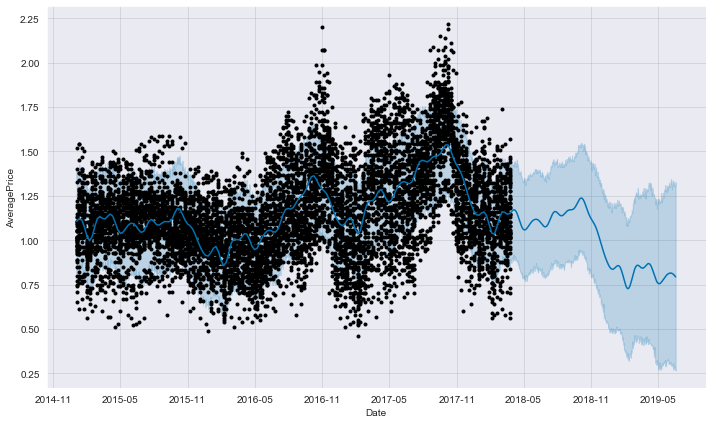

In [222]:
fig7 = m.plot(forecast, xlabel = 'Date', ylabel = 'AveragePrice')

# The trend seems similar to that of organic but as resulted
# conventional avocados are slightly cheaper
# It is intresting to observe that the 2019 prices of avocado seems to reach the record low from 2015 

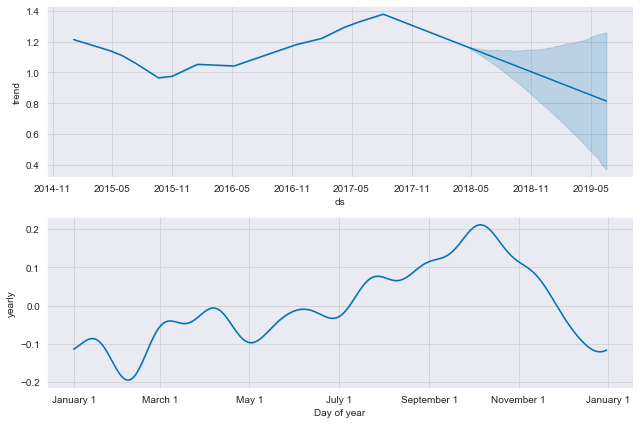

In [223]:
fig8 = m.plot_components(forecast)

In [224]:
# Analysing the model with real data of 2019